In [17]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import numpy as np
from __future__ import division
import statsmodels.api as sm
from scipy.stats import pearsonr
import seaborn as sns

mpl.rcParams['figure.figsize'] = (13,8)
sns.set_context("talk", font_scale=1.0)

In [2]:
notas = pd.read_csv("notas_2014_2017.csv")
cpa = pd.read_csv("cpa.csv")

In [3]:
# Adicionar campo EAD a notas e cpa

notas["COD_DISCIPLINA"] = notas["COD_DISCIPLINA"].apply(lambda x: "0%s"%x if len(x)<7 else x)

In [4]:
def diff_semestres(per1,per2):
    [ano1,sem1] = per1.split("/")
    [ano2,sem2] = per2.split("/")
    d = 2*(int(ano2) - int(ano1))
    return d + (int(sem2)-int(sem1)) + 1
       
notas['diferenca_disciplina_ingresso'] = notas.apply(lambda x:diff_semestres(x['INGRESSO'],x['PERIODO']),axis=1)


In [5]:
cpa["nr_respostas"] = cpa["excelente"] + cpa["muito_bom"] + cpa["bom"] + cpa["regular"] + cpa["insuficiente"]

In [6]:
# Cálculo da nota baseado nas contagens. Está com a escala log proposta.

cpa["nota"] = 0
cpa["nota"] = (1000.0*cpa["excelente"] + 100.0*cpa["muito_bom"] + 10.0*cpa["bom"] + 1.0*cpa["regular"])/cpa["nr_respostas"]

In [7]:
# Simplificação do campo pergunta, removendo a descrição

cpa['topico'] = cpa.pergunta.apply(lambda x:x.split(':')[0].lower())

In [8]:
# Dá um número único a cada topico

cpa['id_pergunta'] = cpa.topico.rank(method='dense')

In [9]:
# Filtrar os dados de interesse da CPA.

cpa_filtered = cpa[(cpa.nr_respostas>=1) & (cpa.nr_respostas<=40)].copy()

In [10]:
turmas_df = cpa_filtered.groupby(list(cpa.columns[1:7])).nota.mean()
turmas_df = turmas_df.to_frame().reset_index()

In [11]:
turmas_df['periodo'] = turmas_df.apply(lambda x:"%s/%s"%(x['ano'],x['base_periodo_id']),axis=1)
turmas_df = turmas_df.rename(columns={'nota':'media_cpa'})

In [12]:
notas_turmas = notas[notas['SITUAÇÃO_DISCIPLINA'].isin(['Aprovado','Reprovado'])].groupby(('COD_DISCIPLINA','PERIODO','TURMA')).NOTA.mean().reset_index()
notas_turmas = notas_turmas.merge(notas[['COD_DISCIPLINA','PERIODO','TURMA','CURSO','UNIDADE']],left_on=['COD_DISCIPLINA','PERIODO','TURMA'],right_on=['COD_DISCIPLINA','PERIODO','TURMA'])

In [13]:
turmas = turmas_df.merge(notas_turmas,left_on=['periodo','cod_atividade','turma_id'],right_on=['PERIODO','COD_DISCIPLINA','TURMA'],how='left')
turmas = turmas.merge(cpa_filtered[list(cpa.columns[1:7])+['nr_respostas']],on=list(cpa.columns[1:7]),how='left')
turmas = turmas.drop_duplicates(['periodo','cod_atividade','turma_id'])
#turmas['unidade_id'] = turmas.UNIDADE.rank(method='dense')
len(turmas)


12887

In [14]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
} 


<IPython.core.display.Javascript object>

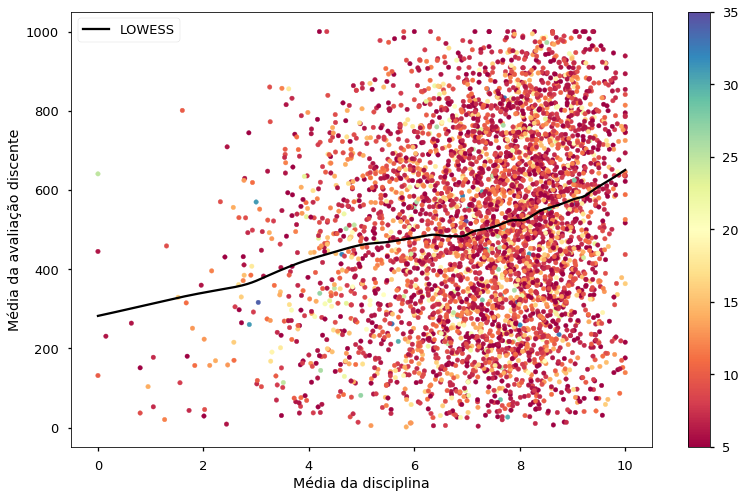

In [18]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral')

lowess = sm.nonparametric.lowess
z = lowess(turmas.media_cpa,turmas.NOTA,frac=0.2)

turmas_filtered = turmas[turmas.nr_respostas>=5]
#print len(turmas_filtered)

# sharex=False é devido a um bug no pandas, que oculta o xlabel com mapas de cores
ax = turmas_filtered.plot(kind='scatter',y='media_cpa',x='NOTA',c=turmas_filtered.nr_respostas,cmap=cmap,sharex=False)
plt.plot(z[:,0],z[:,1],color='black',label='LOWESS')
plt.xlabel(u"Média da disciplina")
plt.ylabel(u"Média da avaliação discente")
plt.legend()
# ax.set_xlim((0,10.5))
# ax.set_ylim((0,10.5))


Text(0,0.5,u'N\xfamero de respostas')

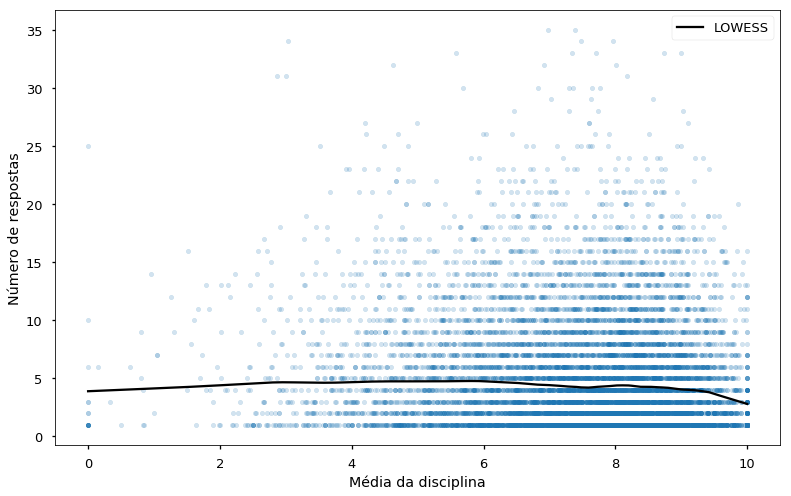

In [19]:
turmas.plot(kind='scatter',y='nr_respostas',x='NOTA',alpha=0.2)
z = lowess(turmas.nr_respostas,turmas.NOTA,frac=0.2)
plt.plot(z[:,0],z[:,1],color='black',label='LOWESS')
plt.legend()
plt.xlabel(u"Média da disciplina")
plt.ylabel(u"Número de respostas")


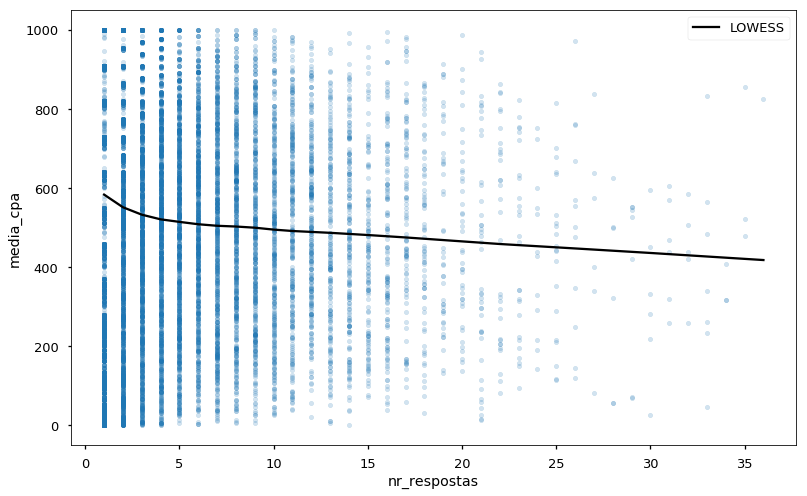

In [20]:
turmas.plot(kind='scatter',x='nr_respostas',y='media_cpa',alpha=0.2)
z = lowess(turmas.media_cpa,turmas.nr_respostas,frac=0.6)
plt.plot(z[:,0],z[:,1],color='black',label='LOWESS')
plt.legend()

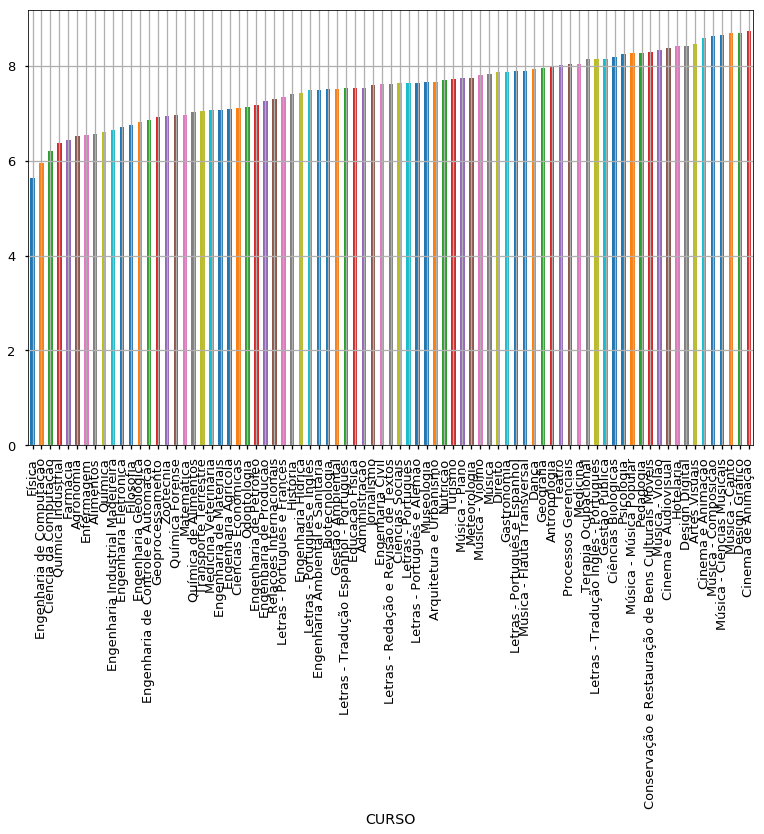

In [21]:
turmas.groupby("CURSO").NOTA.mean().sort_values().plot(kind='bar')
plt.grid()

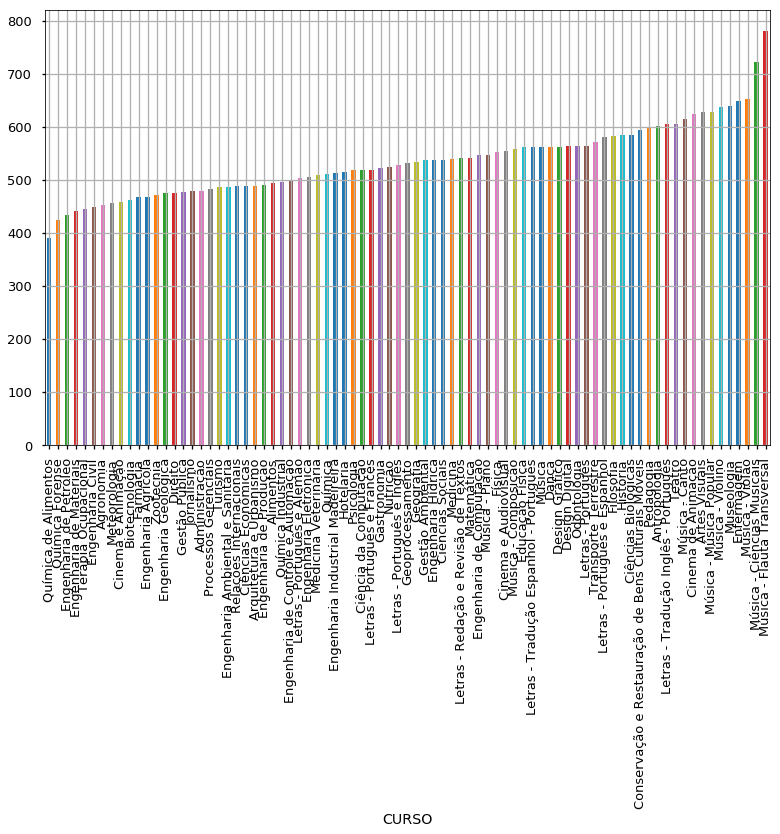

In [22]:
turmas.groupby("CURSO").media_cpa.mean().sort_values().plot(kind='bar')
plt.grid()

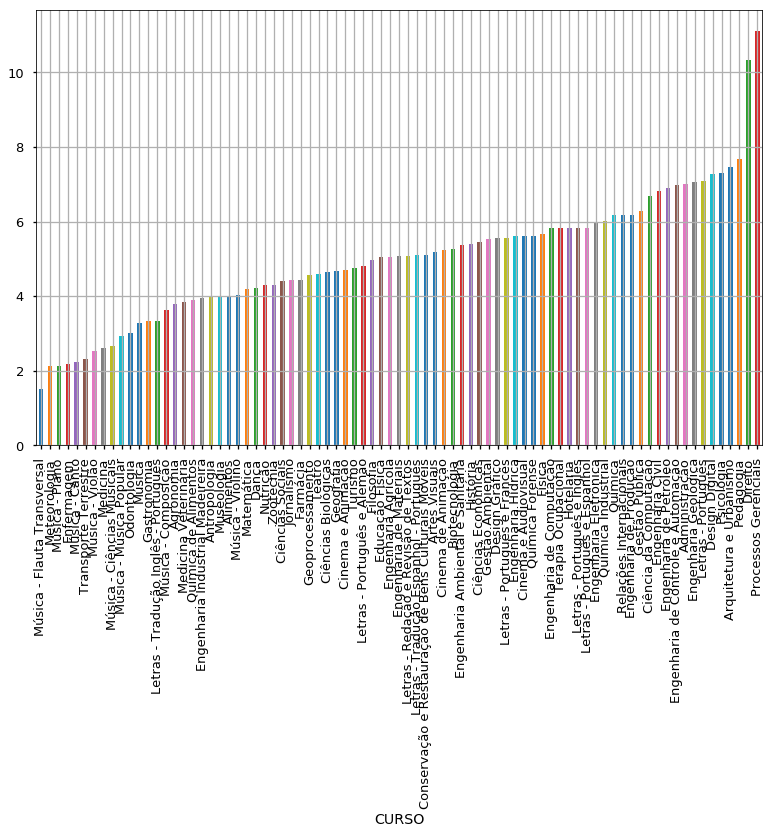

In [23]:
turmas.groupby("CURSO").nr_respostas.mean().sort_values().plot(kind='bar')
plt.grid()

- Calcular o percentual de respostas (nr_respostas / (matriculados-trancados)), plotar por curso/unidad  ver se há diferenças
- Correlação entre notas de perguntas diferentes
- Como se correlacionam notas dentro de uma edição de disciplina
- Como se correlacionam notas de professores que deram a mesma disciplina
- Os professores melhoram/pioram suas avaliações após receberem os resultados? Apenas 2016/2 para 2017/1.
- Avaliação discente varia com o semestre da disciplina?

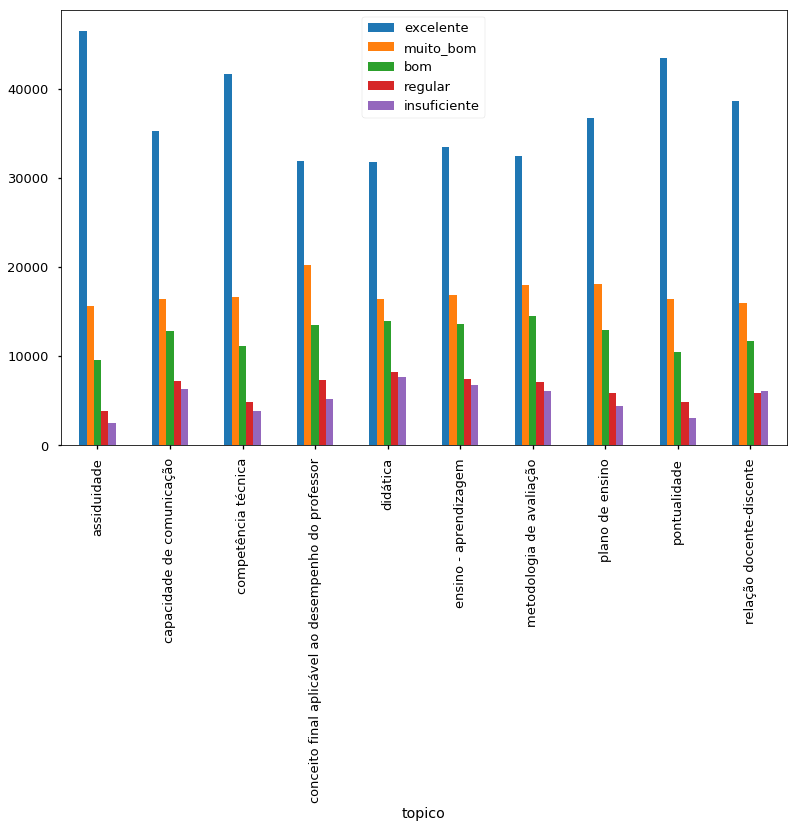

In [24]:
## Histograma da soma de cada resposta, agrupado por pergunta

cpa_topico = cpa_filtered[['topico', 'excelente','muito_bom','bom','regular','insuficiente']].groupby(cpa_filtered.topico)
cpa_topico.sum().plot.bar()

OBSERVACAO:

- Para calcular a correlacao foi utilizada a funcao de Pearson, que retorna valores de -1 a 1, onde valores proximos de 0 indicam que nao ha correlacao entre os dados, valores proximos a -1 indicam uma correlacao negativa e valores proximos a 1 indicam uma correlacao positiva.

In [25]:
## Cria dataframe com o indice de correlacao entre cada resposta, de cada pergunta, calculado pela funcao pearsonr

opcoes = ['excelente', 'muito_bom', 'bom', 'regular', 'insuficiente']
topicos = cpa_filtered['topico'].unique()
t1 = []
t2 = []
c_excelente = []
c_muito_bom = []
c_bom = []
c_regular = []
c_insuficiente = []
for topico in topicos:
    for topico2 in topicos:
        if topico != topico2:
            tmp = []
            for op in opcoes:
                a1=cpa_filtered[(cpa_filtered['topico'] == topico)][op]
                a2=cpa_filtered[(cpa_filtered['topico'] == topico2)][op]

                r, p = pearsonr(a1, a2)

                tmp.append((op, r))

            t1.append(topico)
            t2.append(topico2)

            for opc, co in tmp:
                if opc == 'excelente':
                    c_excelente.append(co)
                elif opc == 'muito_bom':
                    c_muito_bom.append(co)
                elif opc == 'bom':
                    c_bom.append(co)
                elif opc == 'regular':
                    c_regular.append(co)
                elif opc == 'insuficiente':
                    c_insuficiente.append(co)
#                 respostas.append((topico, topico2, op, r, p))
            
corr = pd.DataFrame(
    {"topico1" : t1,
     "topico2" : t2,
     "c_excelente" : c_excelente,
     "c_muito_bom" : c_muito_bom,
     "c_bom" : c_bom,
     "c_regular" : c_regular,
     "c_insuficiente" : c_insuficiente})

len(corr)

90

In [26]:
## Tabela de correlacao de todas as perguntas para a resposta EXCELENTE

pd.pivot_table(corr, values='c_excelente', index=['topico1'], columns=['topico2'])

topico2,assiduidade,capacidade de comunicação,competência técnica,conceito final aplicável ao desempenho do professor,didática,ensino - aprendizagem,metodologia de avaliação,plano de ensino,pontualidade,relação docente-discente
topico1,,,,,,,,,,
assiduidade,NaN,0.777103,0.821011,0.809063,0.772205,0.784963,0.789765,0.862337,0.910211,0.797510
capacidade de comunicação,0.777103,NaN,0.893410,0.909627,0.916121,0.917675,0.879166,0.883533,0.788237,0.890969
competência técnica,0.821011,0.893410,NaN,0.872468,0.875931,0.900037,0.867825,0.885171,0.824855,0.876310
conceito final aplicável ao desempenho do professor,0.809063,0.909627,0.872468,NaN,0.917487,0.918574,0.903131,0.891419,0.815179,0.891698
didática,0.772205,0.916121,0.875931,0.917487,NaN,0.932208,0.898883,0.873709,0.782737,0.872708
ensino - aprendizagem,0.784963,0.917675,0.900037,0.918574,0.932208,NaN,0.903187,0.885070,0.794096,0.896297
metodologia de avaliação,0.789765,0.879166,0.867825,0.903131,0.898883,0.903187,NaN,0.875183,0.803940,0.879100
plano de ensino,0.862337,0.883533,0.885171,0.891419,0.873709,0.885070,0.875183,NaN,0.864112,0.865759
pontualidade,0.910211,0.788237,0.824855,0.815179,0.782737,0.794096,0.803940,0.864112,NaN,0.793697


In [27]:
## Tabela de correlacao de todas as perguntas para a resposta MUITO BOM

pd.pivot_table(corr, values='c_muito_bom', index=['topico1'], columns=['topico2'])

topico2,assiduidade,capacidade de comunicação,competência técnica,conceito final aplicável ao desempenho do professor,didática,ensino - aprendizagem,metodologia de avaliação,plano de ensino,pontualidade,relação docente-discente
topico1,,,,,,,,,,
assiduidade,NaN,0.587283,0.612828,0.622786,0.561928,0.588550,0.600210,0.660566,0.756172,0.617082
capacidade de comunicação,0.587283,NaN,0.709305,0.759462,0.747277,0.748807,0.696626,0.707028,0.605888,0.703519
competência técnica,0.612828,0.709305,NaN,0.718124,0.666240,0.695488,0.683305,0.688482,0.633644,0.681389
conceito final aplicável ao desempenho do professor,0.622786,0.759462,0.718124,NaN,0.749722,0.776643,0.754131,0.742781,0.645630,0.723574
didática,0.561928,0.747277,0.666240,0.749722,NaN,0.769794,0.713889,0.688908,0.582640,0.667622
ensino - aprendizagem,0.588550,0.748807,0.695488,0.776643,0.769794,NaN,0.719998,0.707598,0.614379,0.710222
metodologia de avaliação,0.600210,0.696626,0.683305,0.754131,0.713889,0.719998,NaN,0.700872,0.618478,0.697093
plano de ensino,0.660566,0.707028,0.688482,0.742781,0.688908,0.707598,0.700872,NaN,0.678463,0.673850
pontualidade,0.756172,0.605888,0.633644,0.645630,0.582640,0.614379,0.618478,0.678463,NaN,0.617887


In [28]:
## Tabela de correlacao de todas as perguntas para a resposta BOM

pd.pivot_table(corr, values='c_bom', index=['topico1'], columns=['topico2'])

topico2,assiduidade,capacidade de comunicação,competência técnica,conceito final aplicável ao desempenho do professor,didática,ensino - aprendizagem,metodologia de avaliação,plano de ensino,pontualidade,relação docente-discente
topico1,,,,,,,,,,
assiduidade,NaN,0.532952,0.572621,0.567547,0.520949,0.543077,0.545302,0.637736,0.707010,0.548298
capacidade de comunicação,0.532952,NaN,0.686064,0.759556,0.743093,0.741251,0.683862,0.677730,0.565675,0.677550
competência técnica,0.572621,0.686064,NaN,0.717043,0.648341,0.686875,0.657056,0.672770,0.588197,0.660753
conceito final aplicável ao desempenho do professor,0.567547,0.759556,0.717043,NaN,0.725476,0.762478,0.734355,0.708825,0.606738,0.719703
didática,0.520949,0.743093,0.648341,0.725476,NaN,0.770508,0.698867,0.665119,0.546756,0.652018
ensino - aprendizagem,0.543077,0.741251,0.686875,0.762478,0.770508,NaN,0.705048,0.680552,0.561503,0.689489
metodologia de avaliação,0.545302,0.683862,0.657056,0.734355,0.698867,0.705048,NaN,0.677427,0.577076,0.680401
plano de ensino,0.637736,0.677730,0.672770,0.708825,0.665119,0.680552,0.677427,NaN,0.637882,0.634944
pontualidade,0.707010,0.565675,0.588197,0.606738,0.546756,0.561503,0.577076,0.637882,NaN,0.560836


In [29]:
## Tabela de correlacao de todas as perguntas para a resposta REGULAR

pd.pivot_table(corr, values='c_regular', index=['topico1'], columns=['topico2'])

topico2,assiduidade,capacidade de comunicação,competência técnica,conceito final aplicável ao desempenho do professor,didática,ensino - aprendizagem,metodologia de avaliação,plano de ensino,pontualidade,relação docente-discente
topico1,,,,,,,,,,
assiduidade,NaN,0.385566,0.391344,0.447559,0.396116,0.401303,0.389786,0.475601,0.607107,0.355769
capacidade de comunicação,0.385566,NaN,0.621401,0.721973,0.714085,0.703303,0.618891,0.619025,0.454814,0.619694
competência técnica,0.391344,0.621401,NaN,0.676844,0.588227,0.618285,0.572616,0.588084,0.458746,0.561745
conceito final aplicável ao desempenho do professor,0.447559,0.721973,0.676844,NaN,0.700093,0.725492,0.683765,0.671089,0.522853,0.653649
didática,0.396116,0.714085,0.588227,0.700093,NaN,0.737641,0.634814,0.603395,0.454150,0.602884
ensino - aprendizagem,0.401303,0.703303,0.618285,0.725492,0.737641,NaN,0.634771,0.616579,0.467919,0.624096
metodologia de avaliação,0.389786,0.618891,0.572616,0.683765,0.634814,0.634771,NaN,0.595188,0.454921,0.611219
plano de ensino,0.475601,0.619025,0.588084,0.671089,0.603395,0.616579,0.595188,NaN,0.515025,0.551438
pontualidade,0.607107,0.454814,0.458746,0.522853,0.454150,0.467919,0.454921,0.515025,NaN,0.421829


In [30]:
## Tabela de correlacao de todas as perguntas para a resposta INSUFICIENTE

pd.pivot_table(corr, values='c_insuficiente', index=['topico1'], columns=['topico2'])

topico2,assiduidade,capacidade de comunicação,competência técnica,conceito final aplicável ao desempenho do professor,didática,ensino - aprendizagem,metodologia de avaliação,plano de ensino,pontualidade,relação docente-discente
topico1,,,,,,,,,,
assiduidade,NaN,0.379859,0.395609,0.494866,0.411830,0.425170,0.396851,0.550162,0.658259,0.371811
capacidade de comunicação,0.379859,NaN,0.800113,0.857937,0.892048,0.875963,0.776195,0.760486,0.494598,0.777115
competência técnica,0.395609,0.800113,NaN,0.808269,0.775314,0.776663,0.683474,0.717878,0.478393,0.663237
conceito final aplicável ao desempenho do professor,0.494866,0.857937,0.808269,NaN,0.852760,0.865913,0.820944,0.814092,0.591427,0.790383
didática,0.411830,0.892048,0.775314,0.852760,NaN,0.907053,0.796525,0.755930,0.502941,0.782145
ensino - aprendizagem,0.425170,0.875963,0.776663,0.865913,0.907053,NaN,0.812402,0.764933,0.515729,0.822701
metodologia de avaliação,0.396851,0.776195,0.683474,0.820944,0.796525,0.812402,NaN,0.734014,0.518249,0.772259
plano de ensino,0.550162,0.760486,0.717878,0.814092,0.755930,0.764933,0.734014,NaN,0.594448,0.684570
pontualidade,0.658259,0.494598,0.478393,0.591427,0.502941,0.515729,0.518249,0.594448,NaN,0.486350


(0.3, 1.0)

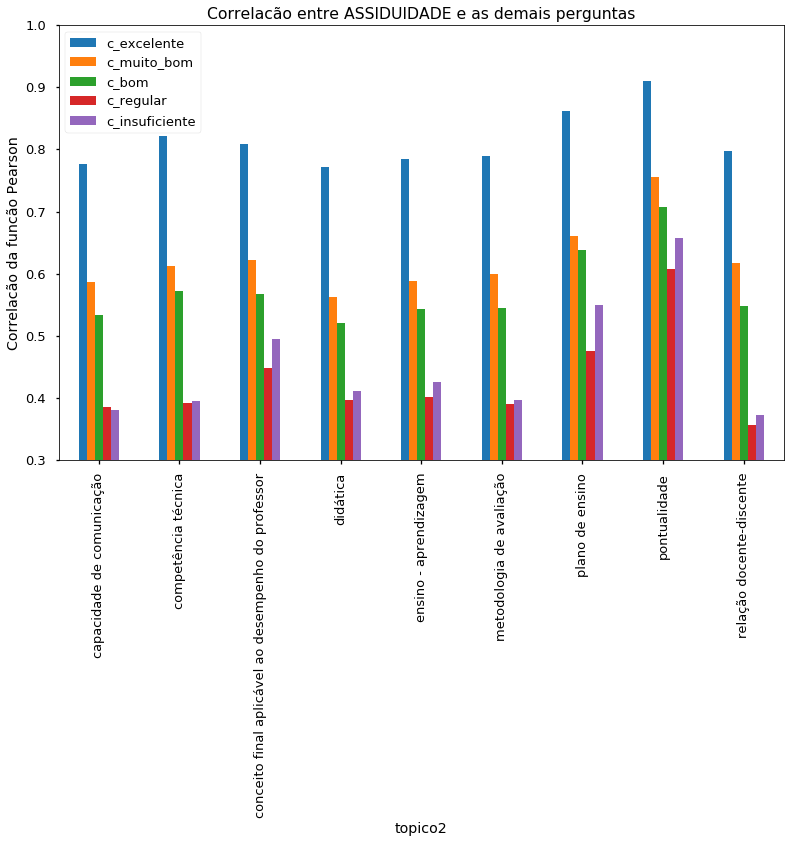

In [31]:
corr_group = corr[corr['topico1'] == 'assiduidade'][['topico2', 'c_excelente', 'c_muito_bom', 'c_bom', 'c_regular', 'c_insuficiente']].groupby(corr.topico2)
corr_group.mean().plot(kind='bar')
plt.legend()
plt.title("Correlacão entre ASSIDUIDADE e as demais perguntas".decode('utf-8'))
plt.ylabel("Correlacão da funcão Pearson".decode('utf-8'))
plt.ylim([0.3,1.0])

(0.3, 1.0)

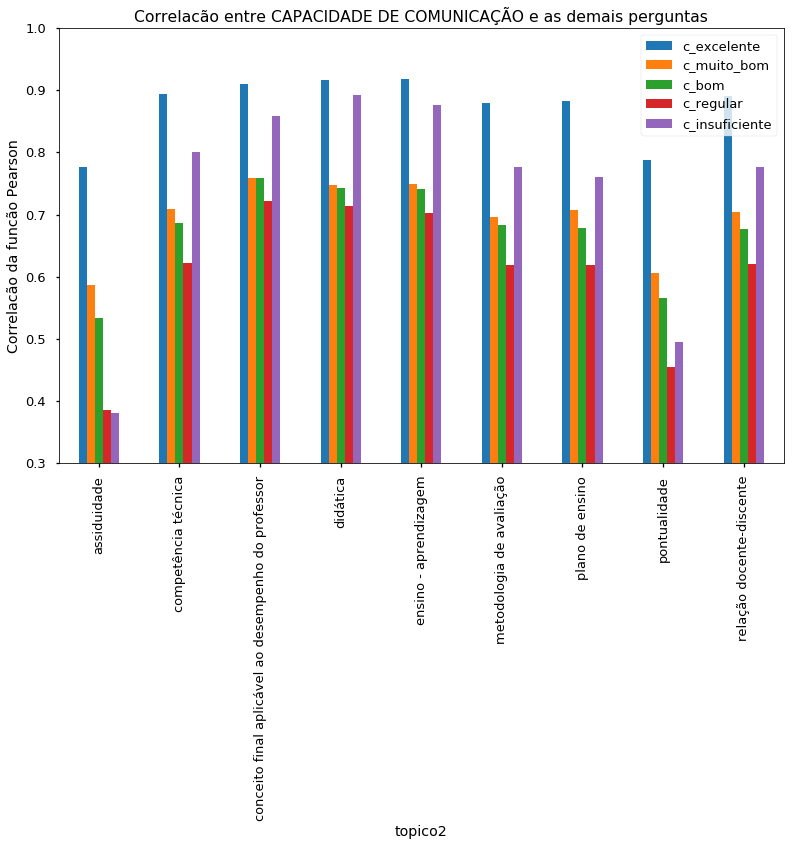

In [32]:
corr_group = corr[corr['topico1'] == 'capacidade de comunicação'][['topico2', 'c_excelente', 'c_muito_bom', 'c_bom', 'c_regular', 'c_insuficiente']].groupby(corr.topico2)
corr_group.mean().plot(kind='bar')
plt.legend()
plt.title("Correlacão entre CAPACIDADE DE COMUNICAÇÃO e as demais perguntas".decode('utf-8'))
plt.ylabel("Correlacão da funcão Pearson".decode('utf-8'))
plt.ylim([0.3,1.0])

(0.3, 1.0)

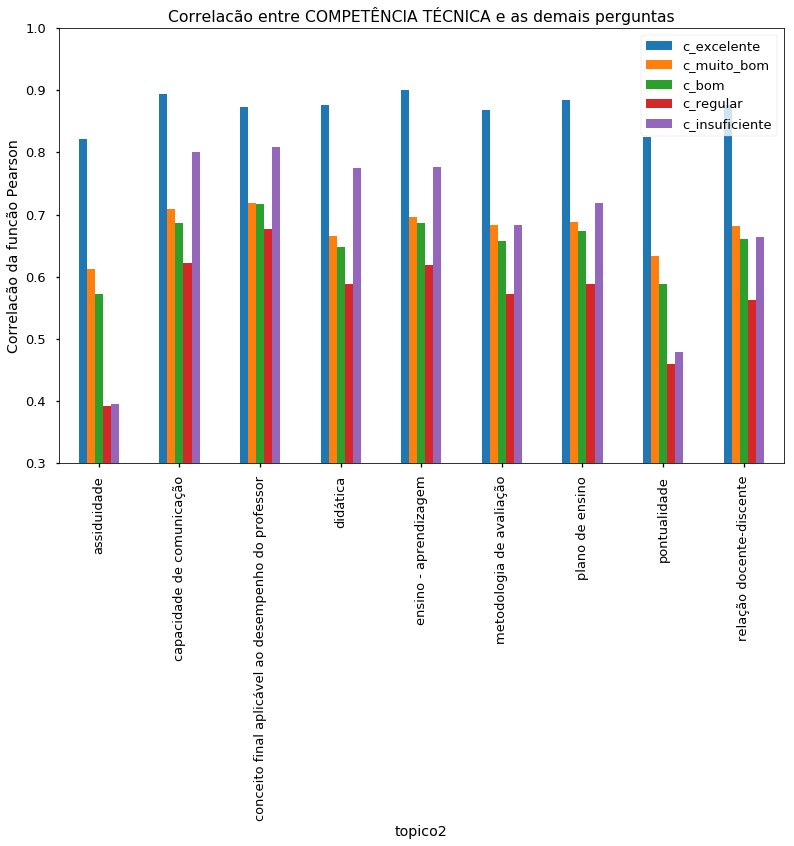

In [33]:
corr_group = corr[corr['topico1'] == 'competência técnica'][['topico2', 'c_excelente', 'c_muito_bom', 'c_bom', 'c_regular', 'c_insuficiente']].groupby(corr.topico2)
corr_group.mean().plot(kind='bar')
plt.legend()
plt.title("Correlacão entre COMPETÊNCIA TÉCNICA e as demais perguntas".decode('utf-8'))
plt.ylabel("Correlacão da funcão Pearson".decode('utf-8'))
plt.ylim([0.3,1.0])

(0.3, 1.0)

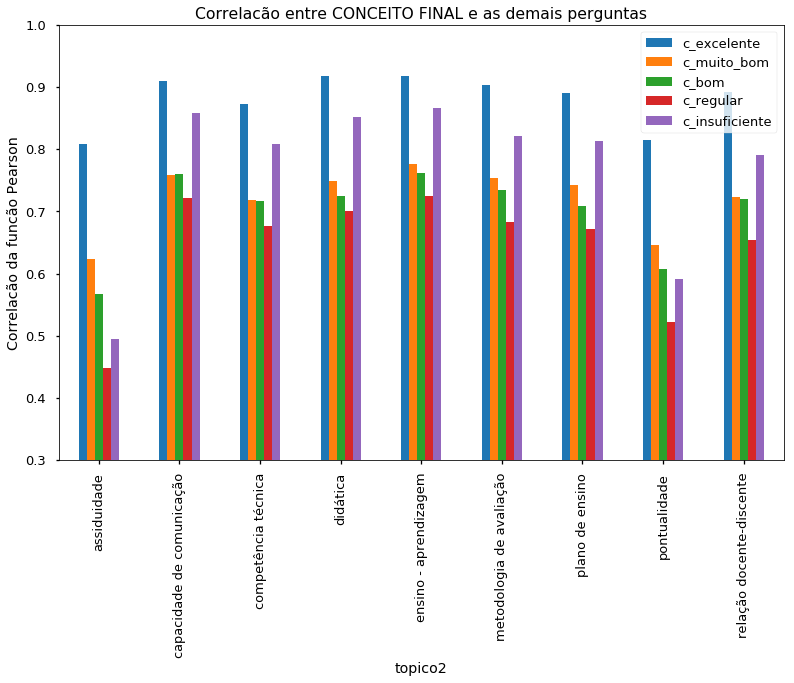

In [34]:
corr_group = corr[corr['topico1'] == 'conceito final aplicável ao desempenho do professor'][['topico2', 'c_excelente', 'c_muito_bom', 'c_bom', 'c_regular', 'c_insuficiente']].groupby(corr.topico2)
corr_group.mean().plot(kind='bar')
plt.legend()
plt.title("Correlacão entre CONCEITO FINAL e as demais perguntas".decode('utf-8'))
plt.ylabel("Correlacão da funcão Pearson".decode('utf-8'))
plt.ylim([0.3,1.0])

(0.3, 1.0)

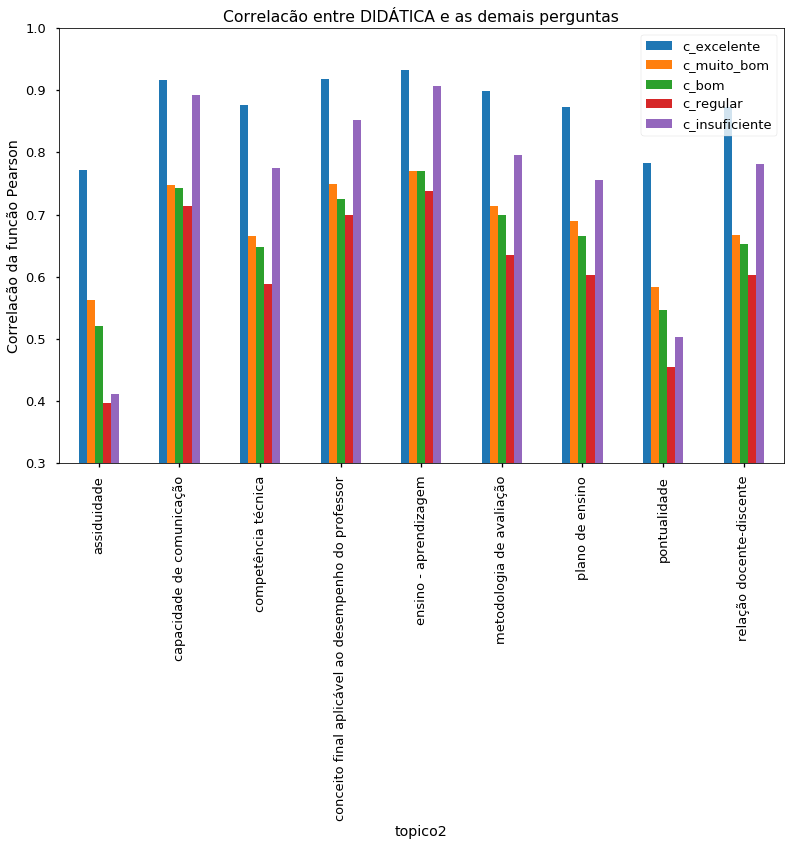

In [35]:
corr_group = corr[corr['topico1'] == 'didática'][['topico2', 'c_excelente', 'c_muito_bom', 'c_bom', 'c_regular', 'c_insuficiente']].groupby(corr.topico2)
corr_group.mean().plot(kind='bar')
plt.legend()
plt.title("Correlacão entre DIDÁTICA e as demais perguntas".decode('utf-8'))
plt.ylabel("Correlacão da funcão Pearson".decode('utf-8'))
plt.ylim([0.3,1.0])

(0.3, 1.0)

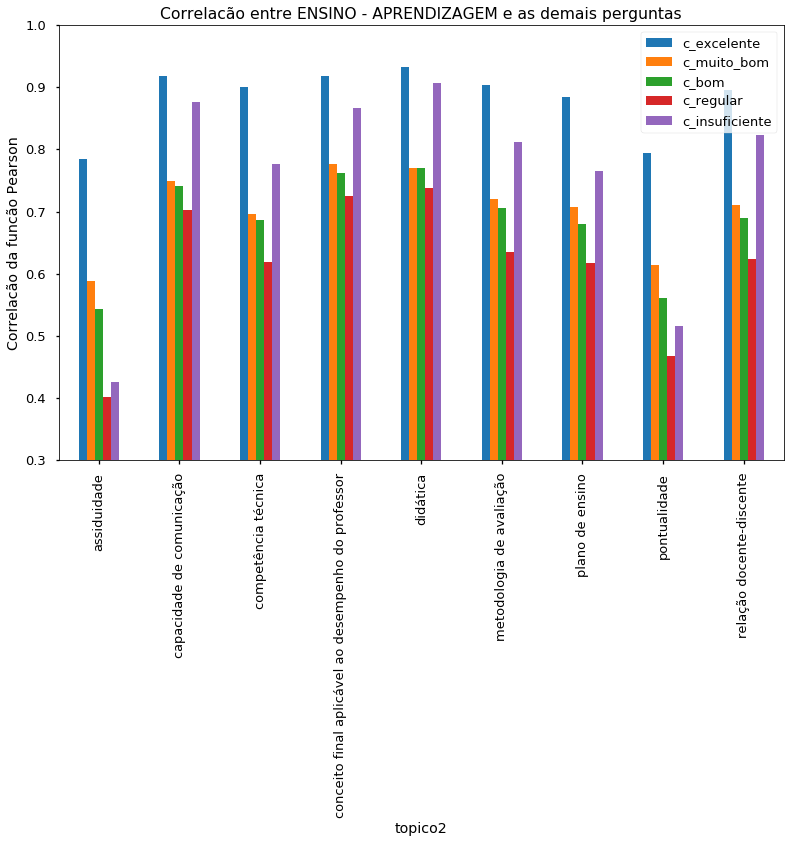

In [36]:
corr_group = corr[corr['topico1'] == 'ensino - aprendizagem'][['topico2', 'c_excelente', 'c_muito_bom', 'c_bom', 'c_regular', 'c_insuficiente']].groupby(corr.topico2)
corr_group.mean().plot(kind='bar')
plt.legend()
plt.title("Correlacão entre ENSINO - APRENDIZAGEM e as demais perguntas".decode('utf-8'))
plt.ylabel("Correlacão da funcão Pearson".decode('utf-8'))
plt.ylim([0.3,1.0])

(0.3, 1.0)

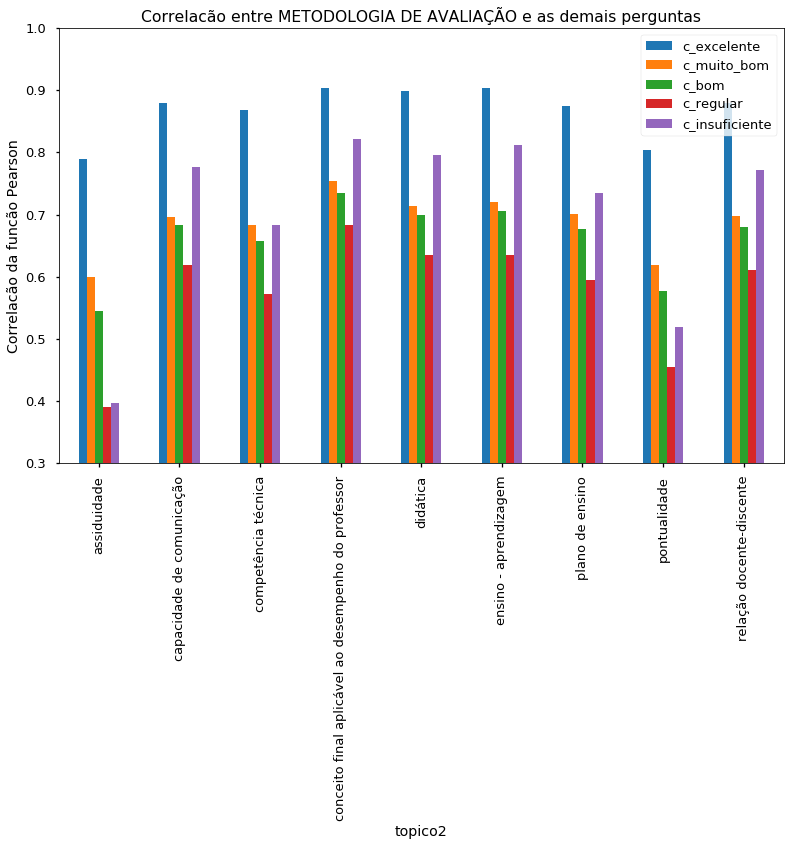

In [37]:
corr_group = corr[corr['topico1'] == 'metodologia de avaliação'][['topico2', 'c_excelente', 'c_muito_bom', 'c_bom', 'c_regular', 'c_insuficiente']].groupby(corr.topico2)
corr_group.mean().plot(kind='bar')
plt.legend()
plt.title("Correlacão entre METODOLOGIA DE AVALIAÇÃO e as demais perguntas".decode('utf-8'))
plt.ylabel("Correlacão da funcão Pearson".decode('utf-8'))
plt.ylim([0.3,1.0])

(0.3, 1.0)

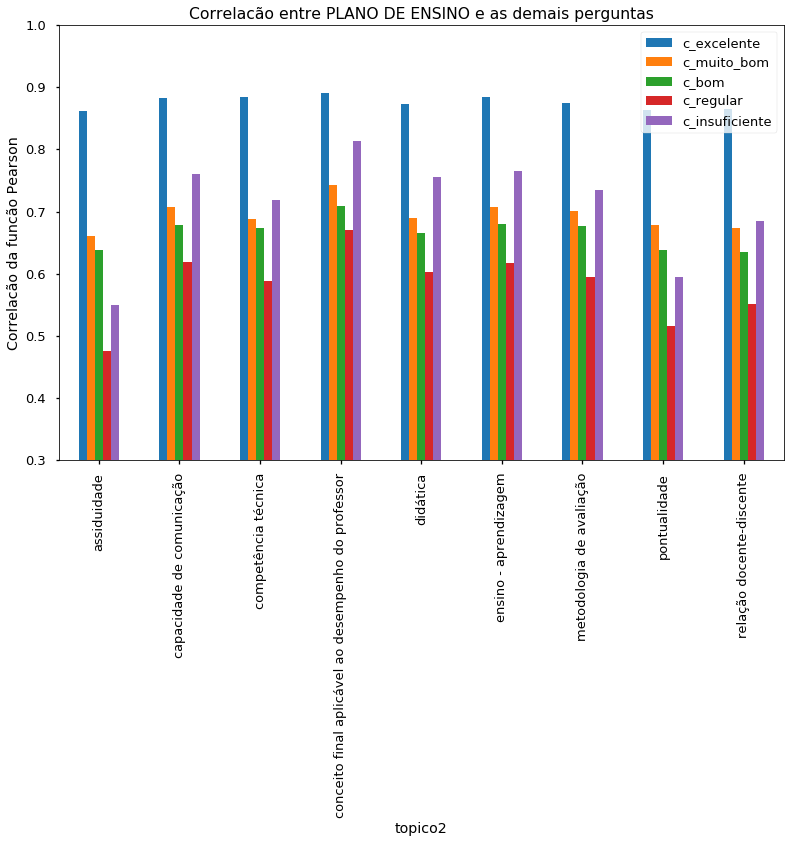

In [38]:
corr_group = corr[corr['topico1'] == 'plano de ensino'][['topico2', 'c_excelente', 'c_muito_bom', 'c_bom', 'c_regular', 'c_insuficiente']].groupby(corr.topico2)
corr_group.mean().plot(kind='bar')
plt.legend()
plt.title("Correlacão entre PLANO DE ENSINO e as demais perguntas".decode('utf-8'))
plt.ylabel("Correlacão da funcão Pearson".decode('utf-8'))
plt.ylim([0.3,1.0])

(0.3, 1.0)

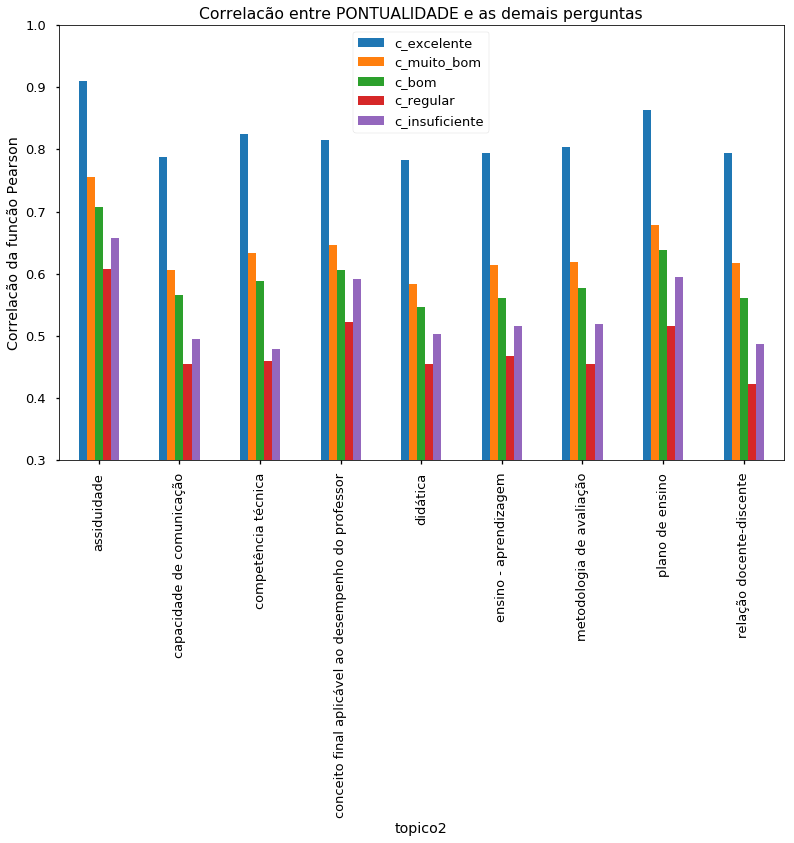

In [39]:
corr_group = corr[corr['topico1'] == 'pontualidade'][['topico2', 'c_excelente', 'c_muito_bom', 'c_bom', 'c_regular', 'c_insuficiente']].groupby(corr.topico2)
corr_group.mean().plot(kind='bar')
plt.legend()
plt.title("Correlacão entre PONTUALIDADE e as demais perguntas".decode('utf-8'))
plt.ylabel("Correlacão da funcão Pearson".decode('utf-8'))
plt.ylim([0.3,1.0])

(0.3, 1.0)

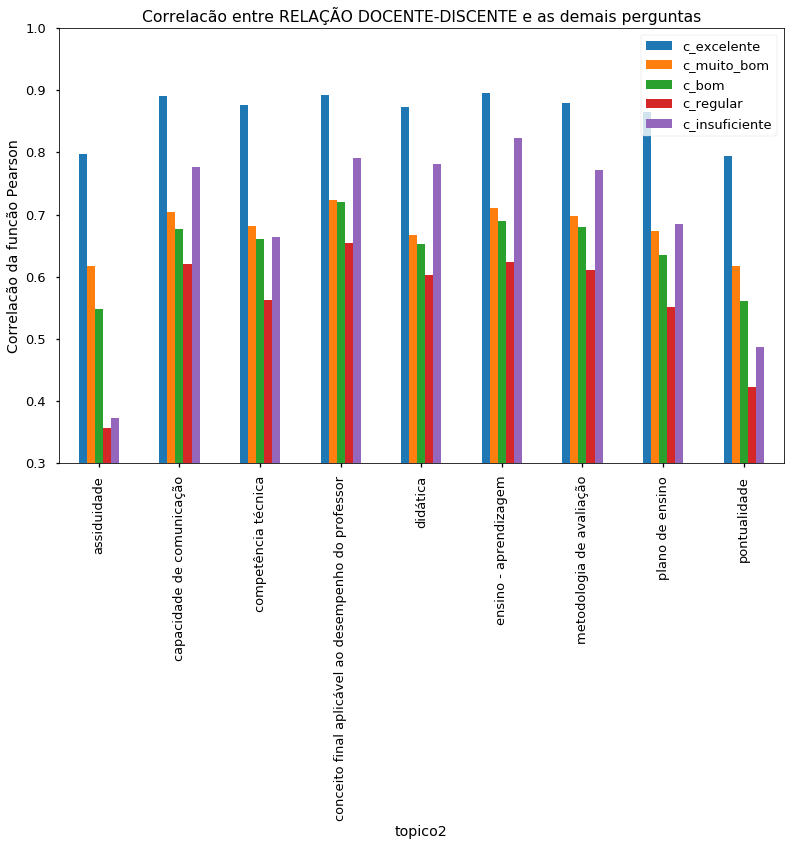

In [40]:
corr_group = corr[corr['topico1'] == 'relação docente-discente'][['topico2', 'c_excelente', 'c_muito_bom', 'c_bom', 'c_regular', 'c_insuficiente']].groupby(corr.topico2)
corr_group.mean().plot(kind='bar')
plt.legend()
plt.title("Correlacão entre RELAÇÃO DOCENTE-DISCENTE e as demais perguntas".decode('utf-8'))
plt.ylabel("Correlacão da funcão Pearson".decode('utf-8'))
plt.ylim([0.3,1.0])

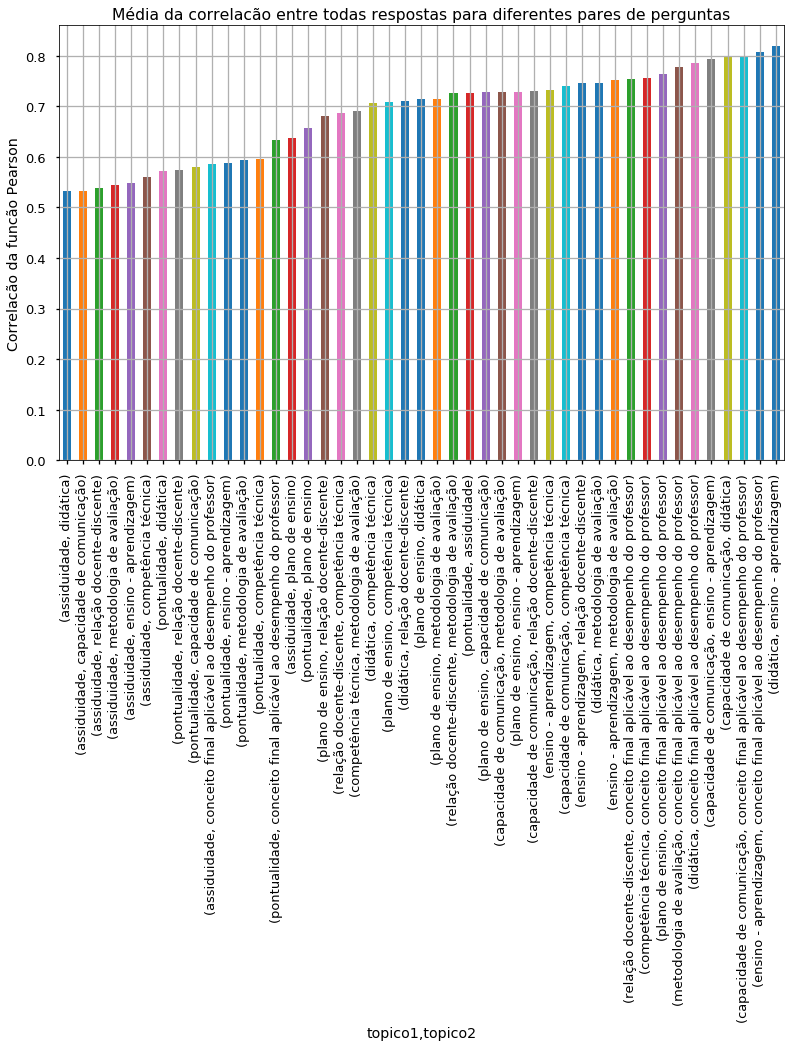

In [50]:
corr['media'] = corr.mean(axis=1)
corr['mediana'] = corr.median(axis=1)
corr_no_dupl = corr.drop_duplicates('media')
corr_no_dupl.set_index(['topico1', 'topico2']).media.sort_values().plot.bar()
plt.title("Média da correlacão entre todas respostas para diferentes pares de perguntas".decode('utf-8'))
plt.ylabel("Correlacão da funcão Pearson".decode('utf-8'))
plt.grid()

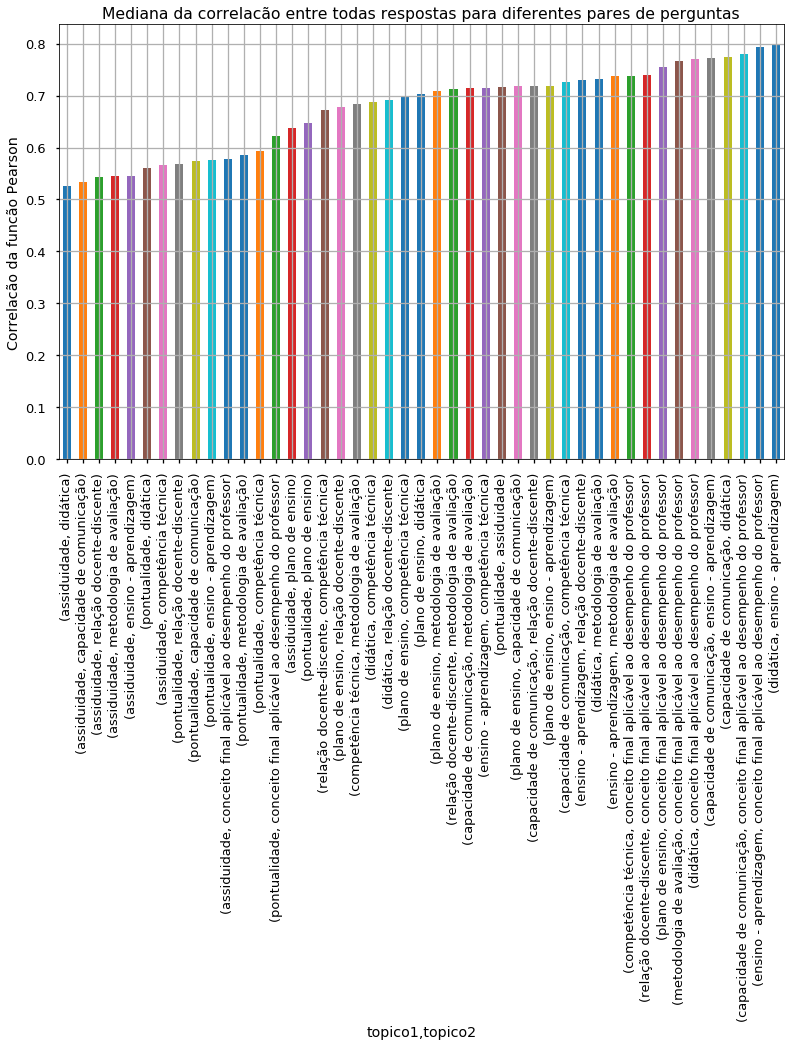

In [51]:
corr_no_dupl.set_index(['topico1', 'topico2']).mediana.sort_values().plot.bar()
plt.title("Mediana da correlacão entre todas respostas para diferentes pares de perguntas".decode('utf-8'))
plt.ylabel("Correlacão da funcão Pearson".decode('utf-8'))
plt.grid()